# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
****

In [17]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels.stats.weightstats as wstats
import scipy.stats as stats

In [18]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [19]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df['Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

/Users/nick/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


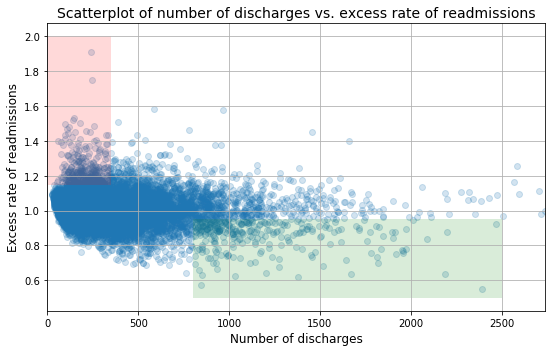

In [20]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

___

## Critique 

In [21]:
clean_hospital_read_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11578 entries, 16857 to 13666
Data columns (total 12 columns):
Hospital Name                 11578 non-null object
Provider Number               11578 non-null int64
State                         11578 non-null object
Measure Name                  11578 non-null object
Number of Discharges          11578 non-null int64
Footnote                      81 non-null float64
Excess Readmission Ratio      11497 non-null float64
Predicted Readmission Rate    11497 non-null float64
Expected Readmission Rate     11497 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    11578 non-null object
End Date                      11578 non-null object
dtypes: float64(5), int64(2), object(5)
memory usage: 1.1+ MB


In [22]:
df_small = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges']<100]
df_large = clean_hospital_read_df[clean_hospital_read_df['Number of Discharges']>1000]
sample_small = df_small['Excess Readmission Ratio']
sample_large = df_large['Excess Readmission Ratio']

print('Number of np.nan value in the array sample_small is',sample_small.size - sample_small.count())
print('Number of np.nan value in the array sample_large is',sample_large.size - sample_large.count())
print('Drop the np.nan entries in array sample_small.')

# drop the np.nan value in the series
sample_small.dropna(inplace=True)
sample_large.dropna(inplace=True)

Number of np.nan value in the array sample_small is 81
Number of np.nan value in the array sample_large is 0
Drop the np.nan entries in array sample_small.


/Users/nick/anaconda/lib/python3.6/site-packages/pandas/core/series.py:2726: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


___

__ 1. Graphical EDA __

In [23]:
def ecdf(data):
    '''Compute ECDF for one-dimensional array of measurements'''
    
    # Number of data points:
    n = len(data)
    
    # x-data for the ECDF:
    x = np.sort(data)
    
    # y-data for the ECDF:
    y = np.arange(1, n+1)/n
    
    return x,y

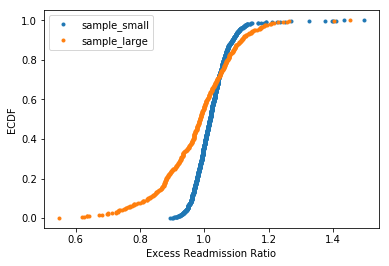

sample_small's (mean, std_dev, size) are (1.023,0.058,1188)
sample_large's (mean, std_dev, size) are (0.978,0.120,463)


In [24]:
x_small,y_small = ecdf(sample_small)
x_large,y_large = ecdf(sample_large)

_ = plt.plot(x_small,y_small,marker='.',linestyle='none')
_ = plt.plot(x_large, y_large, marker='.', linestyle = 'none')
_ = plt.xlabel('Excess Readmission Ratio')
_ = plt.ylabel('ECDF')
_ = plt.legend(('sample_small','sample_large'))
plt.show()

small_mean = sample_small.mean()
large_mean = sample_large.mean()
small_std_dev = sample_small.std()
large_std_dev = sample_large.std()
small_size = sample_small.size
large_size = sample_large.size

print("sample_small's (mean, std_dev, size) are (%.3f,%.3f,%d)"%(small_mean,small_std_dev,small_size))
print("sample_large's (mean, std_dev, size) are (%.3f,%.3f,%d)"%(large_mean,large_std_dev,large_size))

___

__ 2. Hypothesis Test __

The excess readmission ratio is grouped into two samples, named sample small and sample large. Sample-small's corresponding number of discharge less than 100 and sample-large's corresponding number of discharge more than 1000. We want to check whether the difference of mean of this two sample is statistically significant or just by chance. 

* Null hypothesis: 
The observed difference of mean is purely by chance. 

* Alternate hypothesis:
Sample-small's population mean is larger than that of sample-large. 

* Significance level $\alpha$ = .01.

A one-sided two-sample hypothesis test for difference of mean will be used. 

In [25]:
# standard error of mean
SEM = np.sqrt(sample_small.var()/sample_small.size+sample_large.var()/sample_large.size)
# observed difference of mean
obs_diff_mean = sample_small.mean()-sample_large.mean()
# z-score
z_score = obs_diff_mean/SEM
print('The z-score is', z_score)

The z-score is 7.6017424185


In [26]:
# right-sided two-sample test for difference of mean.
z,p = wstats.CompareMeans.from_data(sample_small,sample_large).ztest_ind(alternative='larger',usevar='unequal')
print('z-score is',z)
print('p-value is',p)

z-score is 7.6017424185
p-value is 1.4608491839e-14


Since the p-value is much smaller than the significance level, we can reject the null hypothesis. So the observation in the preliminary report is actully statistically proved to be correct which is that in hospitals/facilities with number of discharges < 100, mean excess readmission rate is smaller than that of hospitals/faclities with numbf of discharges > 1000. 

However, this is not enough to prove the conclusion in the preliminary report which is the rate of readmissions is trending down with increasing number of discharges.

Since the correlation of the two variable could be represented by the slope of a line returned when feeding them into the linear regression model, the appropriate way to prove the conclusion is to use the bootstrap method to generate confidence interval of the slope of lines. 

____

__ 3. Finding the confidence interval of the slope __

In [27]:
def draw_bs_pairs_linreg(x,y,size=1):
    """Perform paris bootstrp for linear regression."""
    
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))
    
    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds,size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i],bs_intercept_reps[i] = np.polyfit(bs_x,bs_y,1)
        
    return bs_slope_reps, bs_intercept_reps

In [28]:
clean_hospital_read_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11578 entries, 16857 to 13666
Data columns (total 12 columns):
Hospital Name                 11578 non-null object
Provider Number               11578 non-null int64
State                         11578 non-null object
Measure Name                  11578 non-null object
Number of Discharges          11578 non-null int64
Footnote                      81 non-null float64
Excess Readmission Ratio      11497 non-null float64
Predicted Readmission Rate    11497 non-null float64
Expected Readmission Rate     11497 non-null float64
Number of Readmissions        11497 non-null float64
Start Date                    11578 non-null object
End Date                      11578 non-null object
dtypes: float64(5), int64(2), object(5)
memory usage: 1.1+ MB


In [29]:
# extract the columns of interest.
interest_df = clean_hospital_read_df.loc[:,['Number of Discharges','Excess Readmission Ratio']]
print('Number of nan entries in the first and second column is %d and %d.'\
      %(interest_df['Number of Discharges'].isnull().sum(),interest_df['Excess Readmission Ratio'].isnull().sum()))
print('Dropping the nan entries.')
interest_df.dropna(inplace=True)
print('Done')

# convert from series to array
disc_num = interest_df['Number of Discharges'].values
excess_readmis_ratio = interest_df['Excess Readmission Ratio'].values

Number of nan entries in the first and second column is 0 and 81.
Dropping the nan entries.
Done


In [30]:
# the observed slope of line produced by linear regression. 
np.polyfit(disc_num,excess_readmis_ratio,1)

array([ -2.90105173e-05,   1.01810615e+00])

In [31]:
# Generate replicates of slope and intercept using pairs boostrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(disc_num,excess_readmis_ratio,1000)

# Compute and print 95% confidence interval for slope
print('The 95% confidence interval of slope is ',np.percentile(bs_slope_reps,[2.5,97.5]))

The 95% confidence interval of slope is  [ -3.53898119e-05  -2.20885521e-05]


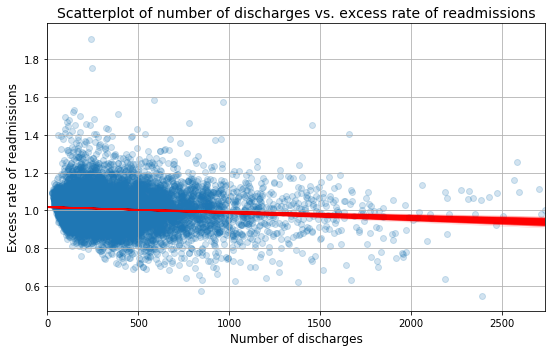

In [32]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# visualise the varaibility by plotting the line you would get from each bootstrap replicate of the slope and intercept.

x_line = np.array([0,max(x)])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

for i in range(1000):
    _ = plt.plot(x_line, bs_slope_reps[i]*x_line+bs_intercept_reps[i],linewidth=0.5, alpha=0.2 ,color='red')

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

__ 4. Conclusion: __

Since the 95% confidence interval of slope is completely below 0, we could then conclude that the rate of readmissions is trending down with increasing number of discharges.

However, statistical significance doesn't mean practical significance. Since the gradient is very small, the cost of reducing the excess rate of readmissions by taking advantage of this the downtrend may not be considered worthy. 